In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
iris = load_iris()
X = iris.data
y = iris.target

df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

print(df.head())
print("\nShape:", df.shape)
print("\nClass distribution:\n", df['target'].value_counts())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Shape: (150, 5)

Class distribution:
 target
0    50
1    50
2    50
Name: count, dtype: int64


       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  


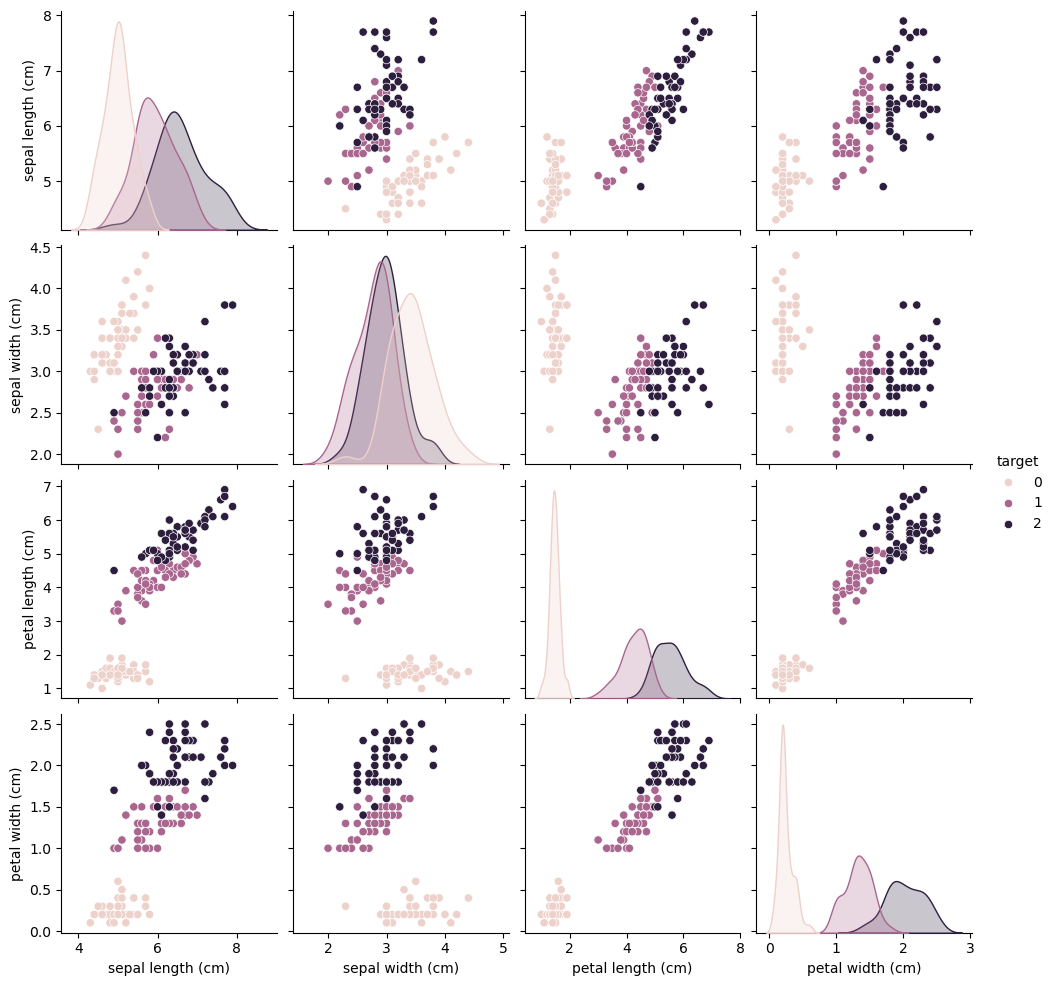

In [5]:
# Summary statistics
print(df.describe())

# Pairplot for visualization
sns.pairplot(df, hue='target', diag_kind='kde')
plt.show()

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Feature Scaling
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

scaled_data = {}
for name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[name] = (X_train_scaled, X_test_scaled)
    print(f"{name} applied: Train shape {X_train_scaled.shape}, Test shape {X_test_scaled.shape}")

StandardScaler applied: Train shape (120, 4), Test shape (30, 4)
MinMaxScaler applied: Train shape (120, 4), Test shape (30, 4)


In [13]:
# Baseline KNN
X_train_std, X_test_std = scaled_data['StandardScaler']

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30


Confusion Matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


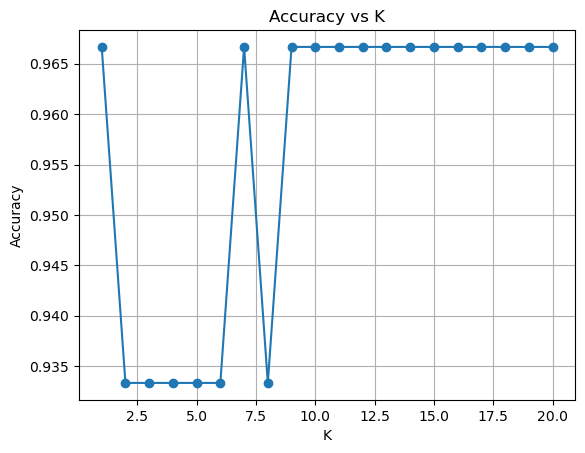

In [19]:
# Accuracy VS K Plot
k_range = range(1, 21)
accuracies = []

for k in k_range:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train_std, y_train)
    y_pred_k = knn_k.predict(X_test_std)
    accuracies.append(accuracy_score(y_test, y_pred_k))

plt.plot(k_range, accuracies, marker='o')
plt.title('Accuracy vs K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

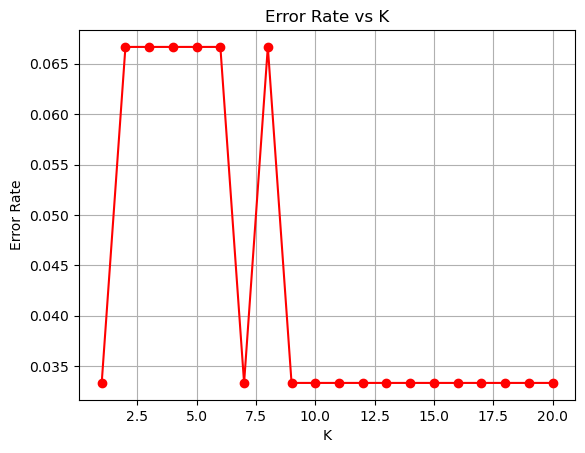

In [21]:
# Error Rate VS K Plot
error_rates = [1 - acc for acc in accuracies]
plt.plot(k_range, error_rates, marker='o', color='red')
plt.title('Error Rate vs K')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

In [23]:
# GridSearchCV for Best K & Metric
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_std, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred_best = best_knn.predict(X_test_std)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Best parameters: {'metric': 'euclidean', 'n_neighbors': 5}
Best CV score: 0.9666666666666668

Test Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [25]:
# Cross-validation Scores
cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')
print("CV scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

CV scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]
Mean CV Accuracy: 0.9733333333333334


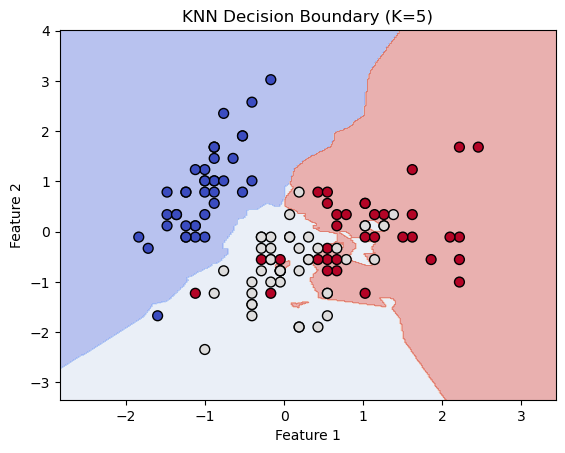

In [27]:
# Decision Boundary Visualization
def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Train a model using only first 2 features for visualization
X_vis = X[:, :2]
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y, test_size=0.2, random_state=42, stratify=y
)
scaler_vis = StandardScaler()
X_train_vis = scaler_vis.fit_transform(X_train_vis)
X_test_vis = scaler_vis.transform(X_test_vis)

knn_vis = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn_vis.fit(X_train_vis, y_train_vis)

plot_decision_boundary(knn_vis, X_train_vis, y_train_vis, f"KNN Decision Boundary (K={grid.best_params_['n_neighbors']})")